In [1]:
import numpy as np
from numpy.linalg import norm
from numpy.random import normal
from scipy.optimize import minimize, Bounds, least_squares
import matplotlib.pyplot as plt
from matplotlib import cm

from typing import NamedTuple
from typing import Callable

# 1. Исходные данные

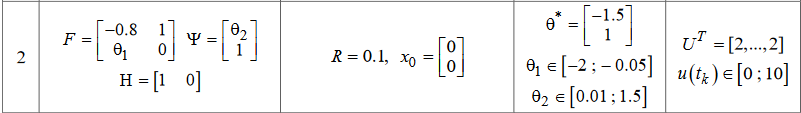

In [415]:
def get_F(th_1: float) -> np.array:
    return np.array([[-0.8, 1], [th_1, 0]])

def get_Psi(th_2: float) -> np.array:
    return np.array([[th_2], [1]])

G = np.array([1, 1]).T
H = np.array([[1, 0]])
R = np.array([[0.1]])
Q = np.array(0.1)
x_0 = np.array([[0], [0]])
th_true = np.array([-5, 2])
th_1_range = [0, 2]
th_2_range = [1, 3]

u_tk = np.array([[2]])

N = 30  # Размерность сигнала U
s = 2  # Размерность th 

U = np.array([(np.ones(N+1)*2)]).T


In [416]:
def check_eigvals(F: np.ndarray) -> None:
    "Проверка собственных значений матрицы F"
    eigenvals = np.linalg.eig(F)[0]
    print(eigenvals)
    on_unit_circle = [False if np.abs(np.imag(eigenval)) > 1 else True for eigenval in eigenvals]
    
    if all(on_unit_circle):
        print('Все значения собственных чисел лежат на комплексной единичной окружности')
    else:
        print('Не все значения собственных чисел лежат на комплексной единичной окружности')
        

In [417]:
check_eigvals(get_F(th_true[0]))

[-0.4+2.2j -0.4-2.2j]
Не все значения собственных чисел лежат на комплексной единичной окружности


# 2. Отклик

In [418]:
class Response(NamedTuple):
    X: np.array
    Y: np.array

def gen_XY(th: np.ndarray, err=1, err2=1) -> Response:
    X = np.zeros((2, N+1))
    Y = np.zeros((N+1, 1))
    F = get_F(th[0])
    Psi = get_Psi(th[1])
    
    X[:, 0] = x_0.flatten()
    Y[0] = H @ X[:, 0] + normal(-np.sqrt(R)/2, np.sqrt(R))*err
    for k in range(1, N+1):
        wi = normal(-np.sqrt(R)/2, np.sqrt(Q), (1,2))*err
        vi = normal(-np.sqrt(Q)/2, np.sqrt(R))*err*err2
        X[:, k] = F @ X[:, k-1] + Psi @ U[k]
        Y[k] = H @ X[:, k] + vi
    return X, Y

In [419]:
class Response(NamedTuple):
    X: np.array
    Y: np.array

def gen_XY(th: np.ndarray, err=1, err2=1) -> Response:
    X = np.zeros((2, N+1))
    Y = np.zeros((N+1, 1))
    F = get_F(th[0])
    Psi = get_Psi(th[1])
    
    X[:, 0] = x_0.flatten()
    Y[0] = H @ X[:, 0] + normal(-np.sqrt(R)/2, np.sqrt(R))*err
    for k in range(1, N+1):
        vi = normal(-np.sqrt(Q)/2, np.sqrt(R))*err*err2
        X[:, k] = F @ X[:, k-1] + Psi @ U[k]
        Y[k] = H @ X[:, k] + vi
    return X, Y
    

# 3. Критерий идентификации

In [420]:
def Hi(th: np.ndarray, Y: np.ndarray) -> np.array:
    m = 1
    v = 1
    F = get_F(th[0])
    Psi = get_Psi(th[1])
    
    Hi = N * m * np.log(2 * np.pi) + N * v * np.log(np.linalg.det(R))
    x_k = x_0
    
    for k in range(N):
        x_k_k = F @ x_k + Psi @ u_tk
        epsilon = Y[k + 1] - H @ x_k_k
        delta = epsilon.T @ np.linalg.inv(R) @ epsilon
        Hi += delta
    return 0.5 * Hi


X, Y = gen_XY(th_true)
print(th_true)
Hi(th_true, Y)

[-5  2]


array([[1.13848024e+22]])

# 4. Градиент критерия

In [421]:
def gradHi(th: np.ndarray, Y: np.ndarray) -> np.array:
    dF = [np.matrix([[0, 0], [0, 0]]), 
          np.matrix([[0, 0], [1, 0]])]
    dPsi = [np.matrix([[0], [0]]), 
            np.matrix([[1], [0]])]
    dx_0 = [np.matrix([[0], [0]]), 
            np.matrix([[0], [0]])]

    v: int = 1
    F: np.matrix = get_F(th[0])
    Psi: np.matrix = get_Psi(th[1])

    gradHi = np.zeros(len(th))
    x_k = x_0
    dx_k = dx_0
    delta = np.zeros((s, 1))
    R_inv = np.linalg.inv(R)
    
    for k in range(N):
        x_k_k = F @ x_k + Psi @ u_tk
        
        dx_k_k = [None, None]
        dEpsilon = [None, None]
        
        for i in range(s):
            dx_k_k[i] = dF[i] @ x_k + F @ dx_k[i] + dPsi[i] @ u_tk
            dEpsilon[i] = - H @ dx_k_k[i]
            epsilon = Y[k + 1] - H @ x_k_k
            delta[i] += (dEpsilon[i].T @ np.linalg.inv(R) @ epsilon).item()
            gradHi[i] += delta[i].item()
        
    return gradHi

gradHi(th_true, Y)

array([ 0.00000000e+00, -5.25872858e+11])

# 5. Подбор параметров

In [422]:
def get_estimate_zero_order(
    Hi: Callable[[np.ndarray, np.ndarray], np.ndarray], 
    th: np.ndarray, 
    Y: np.ndarray
) -> np.ndarray:
    result = minimize(
        method="nelder-mead",
        fun=Hi,
        x0=th,
        bounds=Bounds(th_1_range, th_2_range),
        options={"xatol": 1e-5, "fatol": 1e-5},
        tol=1e-5,
        args=(Y, ),
    )
    return result.x
    

In [423]:
def get_estimate_first_order(
    Hi: Callable[[np.ndarray, np.ndarray], np.ndarray],
    gradHi: Callable[[np.ndarray, np.ndarray], np.ndarray], 
    th: np.ndarray, 
    Y: np.ndarray
) -> np.ndarray:
    result = minimize(
        method="SLSQP",
        fun=Hi,
        x0=th,
        jac=gradHi,
        bounds=Bounds(th_1_range, th_2_range),
        options={"eps": 1e-12, "ftol": 1e-12},
        tol=1e-12,
        args=(Y, ),
    )
    return result.x
    

In [424]:
class EstimateResult(NamedTuple):
    Ys: list[np.array]
    th_est_m0s: np.array
    th_est_m1s: np.array

def get_estimate_result() -> EstimateResult:
    Ys = []
    th_est_m0s = []
    th_est_m1s = []
    
    for i in range(5):
        _, Y = gen_XY(th_true)
        th = np.array([np.random.uniform(*th_1_range), np.random.uniform(*th_2_range)])
        res_m0 = get_estimate_zero_order(Hi, th, Y)
        res_m1 = get_estimate_first_order(Hi, gradHi, th, Y)

        Ys.append(Y)
        th_est_m0s.append(res_m0)
        th_est_m1s.append(res_m1)

    th_est_m0s = np.array(th_est_m0s)
    th_est_m1s = np.array(th_est_m1s)

    return Ys, th_est_m0s, th_est_m1s
    

In [425]:
def show_mean_obs(th_est_m0s: np.ndarray, th_est_m1s: np.ndarray) -> None:
    
    
    mean_th_est_m0 = np.round(np.mean(th_est_m0s[:, 0]), 4), np.round(np.mean(th_est_m0s[:, 1]), 4)
    mean_th_est_m1 = np.round(np.mean(th_est_m1s[:, 0]), 4), np.round(np.mean(th_est_m1s[:, 1]), 4)
    
    print(f"Среднее по 5 наблюдениям:\nM0: {mean_th_est_m0}\nM1: {mean_th_est_m1}")
print(th_true)
Ys, th_est_m0s, th_est_m1s = get_estimate_result()
show_mean_obs(th_est_m0s, th_est_m1s)

[-5  2]
Среднее по 5 наблюдениям:
M0: (0.5738, 3.0)
M1: (0.4705, 2.5488)


C:\Users\Mark\AppData\Local\Temp\ipykernel_16792\3637394808.py:6: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(


In [426]:
class MeanThEst(NamedTuple):
    mean_th_est_m0: np.array
    mean_th_est_m1: np.array

def get_mean_th_est(th_est_m0s: np.ndarray, th_est_m1s: np.ndarray) -> MeanThEst:
    mean_th_est_m0 = np.round(np.mean(th_est_m0s[:, 0]), 4), np.round(np.mean(th_est_m0s[:, 1]), 4)
    mean_th_est_m1 = np.round(np.mean(th_est_m1s[:, 0]), 4), np.round(np.mean(th_est_m1s[:, 1]), 4)
    return mean_th_est_m0, mean_th_est_m1


In [427]:
def _mean(th: np.array) -> np.array:
    Y_ = np.array([gen_XY(th, 1, 0)[1] for _ in range(100)])
    return np.array([np.mean(np.array(Y_)[:, i]) for i in range(N+1)]).reshape(N+1)

In [428]:
def get_Y_est():
    mean_th_est_m0, mean_th_est_m1 = get_mean_th_est(th_est_m0s, th_est_m1s)
    
    Y_mean_obs = np.array([np.mean(np.array(Ys)[:, i]) for i in range(N+1)])
    Y_est_m0 = _mean(mean_th_est_m0)
    Y_est_m1 = _mean(mean_th_est_m1)
    return Y_est_m0, Y_est_m1

In [429]:
def show_errors() -> None:
    Y_mean_obs = np.array([np.mean(np.array(Ys)[:, i]) for i in range(N+1)])
    mean_th_est_m0, mean_th_est_m1 = get_mean_th_est(th_est_m0s, th_est_m1s)
    Y_est_m0, Y_est_m1 = get_Y_est()
    
    dth_m0 = norm(th_true - mean_th_est_m0) / norm(th_true)
    dY_m0 = norm(Y_mean_obs - Y_est_m0) / norm(Y_mean_obs)
    dth_m1 = norm(th_true - mean_th_est_m1) / norm(th_true)
    dY_m1 = norm(Y_mean_obs - Y_est_m1) / norm(Y_mean_obs)
    
    print("0-ой порядок:")
    print(f"Ошибка в пространстве параметров: {dth_m0}")
    print(f"Ошибка в пространстве отклика: {dY_m0}")
    print("1-ый порядок:")
    print(f"Ошибка в пространстве параметров: {dth_m1}")
    print(f"Ошибка в пространстве отклика: {dY_m1}")

show_errors()

0-ой порядок:
Ошибка в пространстве параметров: 1.0515546198941308
Ошибка в пространстве отклика: 1.000000025282763
1-ый порядок:
Ошибка в пространстве параметров: 1.020945330867765
Ошибка в пространстве отклика: 1.0000000043461095


# Графики результатов

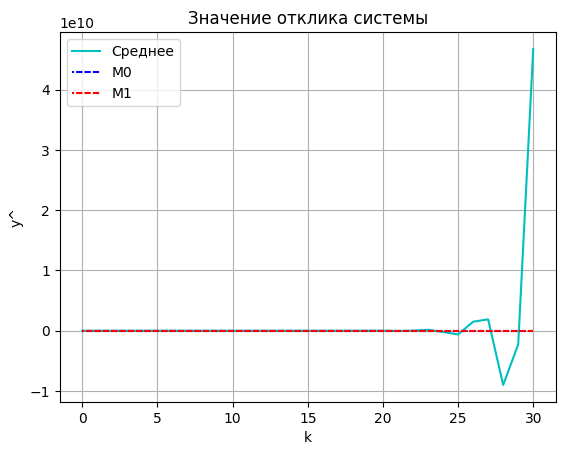

In [430]:
def show_system_responce() -> None:
    Y_mean_obs = np.array([np.mean(np.array(Ys)[:, i]) for i in range(N+1)])
    _x = list(range(len(Y_mean_obs)))
    Y_est_m0, Y_est_m1 = get_Y_est()

    fig, ax = plt.subplots()
    plt.title("Значение отклика системы")
    ax.set_ylabel("y^")
    ax.set_xlabel("k")
    ax.grid(True)
    ax.plot(_x, Y_mean_obs, color='c', linestyle='-', label='Среднее')
    ax.plot(_x, Y_est_m0, color='b', linestyle=(2, (3, 1)), label='M0')
    ax.plot(_x, Y_est_m1, color='r', linestyle=(2, (3, 1)), label='M1')
    ax.legend()

show_system_responce()

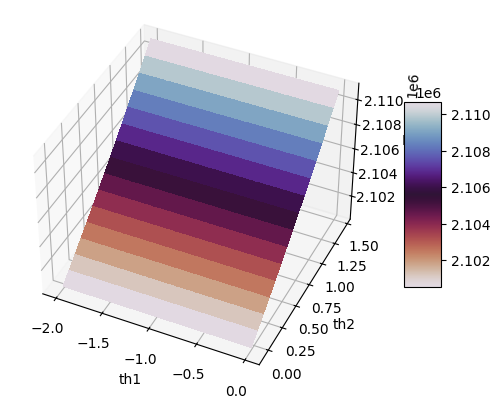

In [398]:
Y_true = gen_XY(th_true, 0, 0)[1]
#%matplotlib widget
step = 0.1
th1a = np.arange(-2, 0.01, step)
th2a = np.arange(-0.05, 1.499, step)
th1, th2 = np.meshgrid(th1a, th2a)
ci = np.array([[Hi(np.array([th1_, th2_]), Y_true) for th1_, th2_ in zip(a,b)] for a,b in zip(th1, th2)])
ci = ci.reshape(16, 21)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(th1, th2, ci, cmap=cm.twilight_r, linewidth=0, antialiased=False)
ax.view_init(40, 295);
ax.set_xlabel('th1')
ax.set_ylabel('th2')
ax.set_zlabel('HI')
fig.colorbar(surf, shrink=0.5, aspect=5);

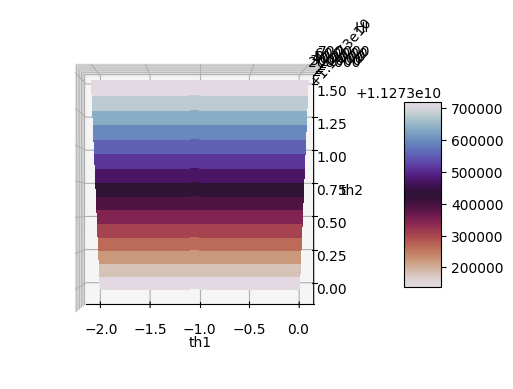

In [152]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(th1, th2, ci, cmap=cm.twilight_r, linewidth=0, antialiased=False)
ax.view_init(89.5, -90);
ax.set_xlabel('th1')
ax.set_ylabel('th2')
ax.set_zlabel('HI')
fig.colorbar(surf, shrink=0.5, aspect=5);